# ERA5 Land Sea Mask

- data: [Copernicus CDS](https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-single-levels?tab=overview)
- download the Copernicus land-sea-mask for one timestep (using ERA5_download_land_sea_mask.py (or Download tool on CDS))
- just double check that nothing changes between 1982 and 2024 (1 January 00:00)
- the land-sea-mask ranges from 0 to 0.5 → create a binary mask
    - proportion of land/water (ocean or inland)
    - lsm > 0.5 → mix of land and inland water but not ocean
    - lsm < 0.5 → can only be water (lake cover could then be used to determine ocean to inland water surface)
- save the binary mask as ERA5_land_sea_mask.nc

In [1]:
import xarray as xr
import os
import cdsapi

## Download

In [2]:
# download the data
os.chdir('/Users/marie-louisekorte/Documents/Uni Leipzig/Lisbon/Data.nosync/')

c = cdsapi.Client()
for YEAR in ['1982','2024']:
    c.retrieve(
        'reanalysis-era5-single-levels',
        {
            'product_type': 'reanalysis',
            'variable': 'land_sea_mask',
            'year': '2024',
            'month': '01',
            'day': '01',
            'time': '00:00',
            'area': [
                45, -20, 35,
                -5,
            ],
            'format': 'netcdf',
        },
        f'../Data.nosync/ERA5_land_sea_mask_{YEAR[2:4]}.nc')

2024-04-29 14:04:43,738 INFO Welcome to the CDS
2024-04-29 14:04:43,741 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels
2024-04-29 14:04:43,887 INFO Request is completed
2024-04-29 14:04:43,889 INFO Downloading https://download-0019.copernicus-climate.eu/cache-compute-0019/cache/data3/adaptor.mars.internal-1714386697.074544-14136-14-1f7ae687-eef3-414c-8cbb-525479b838dc.nc to ../Data.nosync/ERA5_land_sea_mask_82.nc (6.4K)
2024-04-29 14:04:44,167 INFO Download rate 23.1K/s                              
2024-04-29 14:04:44,286 INFO Welcome to the CDS
2024-04-29 14:04:44,288 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels
2024-04-29 14:04:44,399 INFO Downloading https://download-0019.copernicus-climate.eu/cache-compute-0019/cache/data3/adaptor.mars.internal-1714386697.074544-14136-14-1f7ae687-eef3-414c-8cbb-525479b838dc.nc to ../Data.nosync/ERA5_land_sea_mask_24.nc (6.4K)
2024-

## Load and compare

In [3]:
# import ERA5 land-sea mask
lsm_82 = xr.open_dataset('ERA5_land_sea_mask_82.nc')
lsm_24 = xr.open_dataset('ERA5_land_sea_mask_24.nc')

In [4]:
# It only has data for one timestep so I removed the time variable
lsm_82 = lsm_82.squeeze('time').drop_vars('time')
lsm_24 = lsm_24.squeeze('time').drop_vars('time')

In [5]:
# compare the datasets (just to duble check that the vars stay the same over the years)
test = lsm_82 == lsm_24

In [6]:
# the number of variables in the land sea mask (2501)
len(test.lsm.values.flatten())

2501

In [7]:
# sum the 'True' values where lsm_82 and lsm_24 agree -> 2501 -> matches the number of variables -> i.e. are the same
test.lsm.sum() 

<xarray.DataArray 'lsm' ()> Size: 8B
array(2501)

## Make mask binary

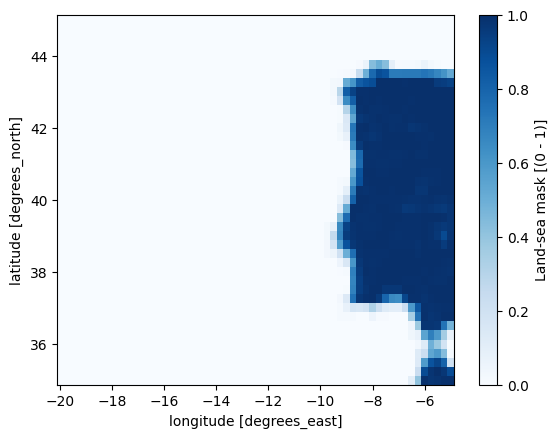

In [8]:
# the values in the mask range between 0-1
    # proportion of land/water (ocean or inland)
    # lsm > 0.5 → mix of land and inland water but not ocean
    # lsm < 0.5 → can only be water (lake cover could then be used to determine ocean to inland water surface)
lsm_82.lsm.plot(cmap = 'Blues')

In [9]:
# ERA5 docs only specify for > and < 0.5 -> check if there are any == 0.5 values in the land sea mask (lsm)
# no 0.5 values in this dataset
(lsm_82.lsm == 0.5).sum()

<xarray.DataArray 'lsm' ()> Size: 8B
array(0)

In [10]:
# make a binary mask out of this
    # where the condition is true the original value stays -> where it is false it gets replaced with the value I specify
    # i.e. where lsm < 0.5 I have water (here water = ocean, lakes are to small/do not lead to lsm < 0.5) 
    # I want all regions where I do not have water (i.e. lsm < 0.5 is False) to be replaced with 0s
# step 1: ocean = 0, land = 1
lsm_82 = lsm_82.where(lsm_82.lsm > 0.5, 0) # land
lsm_82 = lsm_82.where(lsm_82.lsm < 0.5, 1) # water

# setp 2: I want to swap the values around -> ocean = 1 (True), land = 0 (False)
lsm_82['lsm'] = 1 - lsm_82.lsm

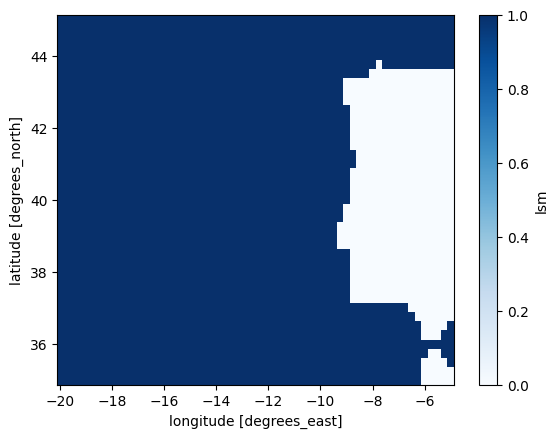

In [11]:
lsm_82.lsm.plot(cmap = 'Blues')

In [12]:
# set attrs and update the name of the coordinates to match the ERA5 mean trubulent surface stress dataset
lsm_82.lsm.attrs.update({"long_name" : "Land-sea mask", "standard_name" : "land_binary_mask", 
                         "units" : "1 (True) : ocean \n0 (False): land"})
lsm_82 = lsm_82.rename({'longitude' : 'lon', 'latitude' : 'lat'})
# change the mask variable to a boolean datatype
lsm_82 = lsm_82.astype(bool)

In [14]:
lsm_82

<xarray.Dataset> Size: 3kB
Dimensions:  (lat: 41, lon: 61)
Coordinates:
  * lon      (lon) float32 244B -20.0 -19.75 -19.5 -19.25 ... -5.5 -5.25 -5.0
  * lat      (lat) float32 164B 45.0 44.75 44.5 44.25 ... 35.75 35.5 35.25 35.0
Data variables:
    lsm      (lat, lon) bool 3kB True True True True ... False False False False
Attributes:
    Conventions:  CF-1.6
    history:      2024-04-29 10:31:37 GMT by grib_to_netcdf-2.28.1: /opt/ecmw...

## Save

In [15]:
## save as ERA5_land_sea_mask.nc
lsm_82.to_netcdf('Land_sea_mask.nc')